# Neural Network

In [1]:
import numpy
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

#numpy.seterr(all='raise')

def plot(classifier, data, labels, title=None, xlabel=None, ylabel=None):
    unique_labels = np.unique(labels)
    colors = ['red', 'blue', 'green', 'orange', 'cyan'][:len(unique_labels)]
    x1max, x1min = np.max(data[:, 0]), np.min(data[:, 0])
    x2max, x2min = np.max(data[:, 1]), np.min(data[:, 1])
    scale_x1 = x1max - x1min
    scale_x2 = x2max - x2min
    x1max, x1min = x1max + (x1max-x1min)*0.05, x1min - (x1max-x1min)*0.05
    x2max, x2min = x2max + (x2max-x2min)*0.05, x2min - (x2max-x2min)*0.05
    resolution = scale_x1 / 200
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=ListedColormap(colors))
    
    data_of_each_label = {}
    for d, l in zip(data, labels):
        if l in data_of_each_label:
            data_of_each_label[l].append(d)
        else:
            data_of_each_label[l] = [d]
    
    for i in range(len(unique_labels)):
        data = data_of_each_label[unique_labels[i]]
        plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], s=5, c=colors[i])

In [59]:
import numpy as np
from abc import ABCMeta, abstractmethod


class MLPLayer(metaclass=ABCMeta):
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass


class CNNLayer(MLPLayer, metaclass=ABCMeta):
    def im2col(self, img, FH, FW, stride, pad):
        N, C, H, W = img.shape
        #FN, C, FH, FW = filters.shape
        # フィルタ適用後のimageサイズ
        OH = (H + 2*pad - FH) // stride + 1
        OW = (W + 2*pad - FW) // stride + 1
        img_padded = np.pad(img, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, FH, FW, OH, OW))
        for y in range(FH):
            ymax = y + stride * OH
            for x in range(FW):
                xmax = x + stride * OW
                col[:, :, y, x, :, :] = img_padded[:, :, y:ymax:stride, x:xmax:stride]
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*OH*OW, -1)
        return col
    
    def col2im(self, col, img_shape, FH, FW, stride, pad):
        N, C, H, W = img_shape
        #FN, C, FH, FW = filters.shape
        OH = (H + 2*pad - FH) // stride + 1
        OW = (W + 2*pad - FW) // stride + 1
        
        col_reshaped = col.reshape(N, OH, OW, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        
        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        
        for y in range(FH):
            ymax = y + stride * OH
            for x in range(FW):
                xmax = x + stride * OW
                img[:, :, y:ymax:stride, x:xmax:stride] += col_reshaped[:, :, y, x, :, :]
        img = img[:, :, pad:pad+H, pad:pad+W]
        return img


class Affine(MLPLayer):
    def __init__(self, W, b):
        # モデルの重み
        self.W = W
        self.b = b
        # 重みの勾配
        self.dW = None
        self.db = None
        # Adam 用パラメータ
        self.v_W = np.zeros(W.shape)
        self.v_b = np.zeros(b.shape)
        self.h_W = np.zeros(W.shape)
        self.h_b = np.zeros(b.shape)
        # 誤差逆伝播用の中間データ
        self.A = None

    def forward(self, A, is_training=False):
        out = np.dot(A, self.W.T) + self.b
        
        if is_training:
            self.A = A
        return out

    def backward(self, dout):
        dA = np.dot(dout, self.W)
        self.dW = np.dot(dout.T, self.A)
        self.db = dout.sum(axis=0)
        
        self.A = None
        return dA


class Sigmoid(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.sigmoid = None
    
    def forward(self, Z, is_training=False):
        sigmoid = 1.0 / (1.0 + np.exp(-Z))
        
        if is_training:
            self.sigmoid = sigmoid
        return sigmoid
    
    def backward(self, dout):
        dphi = self.sigmoid * (1.0 - self.sigmoid)
        dZ = dout * dphi
        
        self.sigmoid = None
        return dZ


class HyperbolicTangent(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Z = None
    
    def forward(self, Z, is_training=False):
        out = np.tanh(Z)
        
        if is_training:
            self.Z = Z.copy()
        return out
    
    def backward(self, dout):
        dphi = 1.0 / np.cosh(self.Z)**2
        dZ = dout * dphi
        
        self.Z = None
        return dZ


class ReLU(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.mask = None
    
    def forward(self, Z, is_training=False):
        mask = Z <= 0
        out = Z.copy()
        out[mask] = 0
        
        if is_training:
            self.mask = mask
        return out
    
    def backward(self, dout):
        dphi = np.full(self.mask.shape, 1.0)
        dphi[self.mask] = 0
        dZ = dout * dphi
        
        self.mask = None
        return dZ


class SoftMax(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Y = None
    
    def forward(self, Z, is_training=False):
        Z_exp = np.exp(Z)
        Y = (Z_exp.T / Z_exp.sum(axis=1)).T
        
        if is_training:
            self.Y = Y
        return Y
    
    def backward(self, dout):
        dZ = self.Y * (dout.T - np.sum(self.Y * dout, axis=1)).T
        
        self.Y = None
        return dZ


class CostCalculation(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Y_predict = None
        self.Y_correct = None
    
    def forward(self, Y_predict, Y_correct, is_training=False):
        cost = - np.sum(Y_correct * np.log(Y_predict) + (1.0 - Y_correct) * np.log(1.0 - Y_predict), axis=1)
        cost = np.average(cost)
        
        if is_training:
            self.Y_predict = Y_predict
            self.Y_correct = Y_correct
        return cost
    
    def backward(self, dout=1.0):
        batch_size = self.Y_predict.shape[0]
        dA = (self.Y_predict - self.Y_correct) / (self.Y_predict * (1.0 - self.Y_predict)) / batch_size
        
        self.Y_predict = None
        self.Y_correct = None
        return dA


class BatchNormalization(MLPLayer):
    def __init__(self, n_units, eps=1e-8):
        self.eps = eps
        # モデルの重み
        self.gamma = np.full(n_units, 1.0)
        self.beta = np.zeros(n_units)
        # 重みの勾配
        self.dgamma = None
        self.dbeta = None
        # Adam 用パラメータ
        self.v_gamma = np.zeros(self.gamma.shape)
        self.v_beta = np.zeros(self.beta.shape)
        self.h_gamma = np.zeros(self.gamma.shape)
        self.h_beta = np.zeros(self.beta.shape)
        # 誤差逆伝播用の中間データ
        self.std = None
        self.Z_norm = None
    
    def forward(self, Z, is_training=False):
        shape = Z.shape
        Z = Z.reshape(shape[0], -1)
        
        mu = np.average(Z, axis=0)
        std = np.std(Z, axis=0)
        Z_norm = (Z - mu) / np.sqrt(std**2 + self.eps)
        out = self.gamma * Z_norm + self.beta
        
        if is_training:
            self.std = std
            self.Z_norm = Z_norm
        out = out.reshape(shape)
        return out
    
    def backward(self, dout):
        shape = dout.shape
        dout = dout.reshape(shape[0], -1)
        
        n_batch = shape[0]
        self.dgamma = (dout * self.Z_norm).sum(axis=0)
        self.dbeta = dout.sum(axis=0)
        dZ = self.gamma / (n_batch * np.sqrt(self.std**2 + self.eps)) * (
            n_batch * dout - self.dbeta - self.Z_norm * self.dgamma
        )
        dZ = dZ.reshape(shape)
        
        self.std = None
        self.Z_norm = None
        return dZ


class Convolution(CNNLayer):
    """
    Attributes
    ----------
    filters : numpy array (FN, C, FH, FW)
        FN : 出力チャンネル数
        C  : 入力チャンネル数
        FH : フィルタの行数
        FW : フィルタの列数
    bias : numpy array
    stride : 
    pad : 
    """
    def __init__(self, filters, bias, stride=1, pad=0):
        self.stride = stride
        self.pad = pad
        # モデルの重み
        self.filters = filters
        self.bias = bias
        # 重みの勾配
        self.dF = None
        self.db = None
        # Adam 用パラメータ
        self.v_F = np.zeros(self.filters.shape)
        self.v_b = np.zeros(self.bias.shape)
        self.h_F = np.zeros(self.filters.shape)
        self.h_b = np.zeros(self.bias.shape)
        # 誤差逆伝播用の中間データ
        self.img = None
        self.col_img = None
        self.col_filters = None
    
    def forward(self, img, is_training=False):
        FN, C, FH, FW = self.filters.shape
        N, C, H, W = img.shape
        #H, W = H + self.pad * 2, W + self.pad * 2
        
        col_img = self.im2col(img, FH, FW, stride=self.stride, pad=self.pad).T
        col_filters = self.filters.reshape(FN, -1)
        
        OH = (H + self.pad * 2 - FH) // self.stride + 1
        OW = (W + self.pad * 2 - FW) // self.stride + 1
        
        if (OH - 1) * self.stride - self.pad * 2 + FH != H or (OW - 1) * self.stride - self.pad * 2 + FW != W:
            raise Exception('ストライド幅が不適')
        
        if is_training:
            self.img = img
            self.col_img = col_img
            self.col_filters = col_filters
        
        out = (np.dot(col_filters, col_img).T + self.bias).T
        out = out.reshape(FN, N, OH, OW).transpose(1, 0, 2, 3)
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.filters.shape
        #N, C, H, W = dout.shape
        
        dout_reshaped = dout.transpose(0,2,3,1).reshape(-1, FN) # N, H, W, C
        self.db = dout_reshaped.sum(axis=0)
        self.dF = np.dot(self.col_img, dout_reshaped).T.reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout_reshaped, self.col_filters)
        dimg = self.col2im(dcol, self.img.shape, FH, FW, self.stride, self.pad)
        
        self.img = None
        self.col_img = None
        self.col_filters = None
        
        return dimg


class MaxPooling(CNNLayer):
    def __init__(self, PH, PW, stride=1, pad=0):
        self.PH = PH
        self.PW = PW
        self.stride = stride
        self.pad = pad
        self.img = None
        self.max_args = None
    
    def forward(self, img, is_training=False):
        N, C, H, W = img.shape
        OH = (H + self.pad * 2 - self.PH) // self.stride + 1
        OW = (W + self.pad * 2 - self.PW) // self.stride + 1
        
        col_img = self.im2col(img, self.PH, self.PW, self.stride, self.pad).reshape(-1, self.PH*self.PW)
        max_args = col_img.argmax(axis=1)
        out = col_img.max(axis=1).reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
        
        if is_training:
            self.img = img
            self.max_args = max_args
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)  # N, H, W, C
        
        pool_size = self.PH * self.PW
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.max_args.size), self.max_args.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dimg = self.col2im(dcol, self.img.shape, self.PH, self.PW, self.stride, self.pad)
        
        self.img = None
        self.max_args = None
        
        return dimg


class Flatten(MLPLayer):
    def __init__(self):
        self.img_shape = None
    
    def forward(self, img, is_training=False):
        """
        (N, C, H, W) -> (N, C*H*W)
        """
        img_shape = img.shape
        out = img.reshape(img_shape[0], -1)
        
        if is_training:
            self.img_shape = img_shape
        
        return out
    
    def backward(self, dout):
        """
        (N, C*H*W) -> (N, C, H, W)
        """
        dimg = dout.reshape(self.img_shape)
        self.img_shape = None
        return dimg


class Dropout(MLPLayer):
    def __init__(self, ratio=0.5):
        self.ratio = ratio
        self.mask = None
    
    def forward(self, x, is_training=False):
        if is_training:
            self.mask = np.random.rand(*x.shape) > self.ratio
            return x * self.mask
        else:
            return x * (1.0 - self.ratio)
    
    def backward(self, dout):
        dx = dout * self.mask
        self.mask = None
        return dx

In [91]:
import copy
import numpy as np
from datetime import datetime

class SimpleMLPClassifier:
    alpha_h = 0.9
    alpha_v = 0.9
    eps = 1e-12
    
    def __init__(self, h_layers, h_units, epochs, eta, n_batch, l2=0.,
                 hidden_activation_class=ReLU, debug_grad_check=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.l2 = l2
        self.hidden_activation_class = hidden_activation_class
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.cost_train = None
        self.cost_test = None
        self.acc_train = None
        self.acc_test = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = None
    
    def predict(self, data):
        out = data.copy()
        for layer in self.layers:
            out = layer.forward(out)
        i_label = np.argmax(out, axis=1)
        return self.index2label[i_label]
    
    def fit(self, data_train, labels_train, data_test, labels_test):
        if self.layers is None:
            self.index2label = np.unique(labels_train)
            self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        
        N_train = len(data_train)
        N_test = len(data_test)
        L = len(np.unique(labels_train))
        
        X_train = data_train.copy()
        Y_train = np.zeros([N_train, L])
        for i in range(N_train):
            l = labels_train[i]
            Y_train[i][self.label2index[l]] = 1.0
        X_test = data_test.copy()
        Y_test = np.zeros([N_test, L])
        for i in range(N_test):
            l = labels_test[i]
            Y_test[i][self.label2index[l]] = 1.0
        
        if self.layers is None:
            self.initialize_layers(X_train, Y_train)
            self.cost_train = []
            self.cost_test = []
            self.acc_train = []
            self.acc_test = []
            self.grad_err = []
            self.__evaluate(X_train, Y_train, X_test, Y_test)
        
        display_progress = max(self.epochs // 10, 1)
        for epoch in range(1, self.epochs+1):
            for _ in range(N_train // self.n_batch):
                # ミニバッチデータ選択
                ids = np.random.choice(range(N_train), self.n_batch, replace=False)
                X_part = X_train[ids]
                Y_part = Y_train[ids]
                self.__cycle(X_part, Y_part, X_test, Y_test)
            
            self.__evaluate(X_train, Y_train, X_test, Y_test)
            
            if epoch % display_progress == 0:
                now = datetime.now()
                print('[{}] epoch {} finished (acc={}, cost={})'.format(
                    now.strftime('%Y/%m/%d %H:%M:%S'),
                    len(self.cost_train) - 1,
                    self.acc_test[-1],
                    self.cost_test[-1]
                ))
    
    def initialize_layers(self, X_train, Y_train):
        N = X_train.shape[0]
        d = X_train.shape[1]
        
        t = len(self.index2label)
        
        self.layers = []
        n_from = d
        for i in range(self.h_layers):
            n_to = self.h_units
            b = np.random.randn(n_to) * np.sqrt(1.0/(n_from))
            w = np.random.randn(n_to, n_from) * np.sqrt(1.0/(n_from))
            self.layers.extend([
                Affine(w, b),
                BatchNormalization(n_to),
                self.hidden_activation_class()
            ])
            n_from = n_to
        n_to = t
        w = np.random.randn(n_to, n_from) * np.sqrt(1.0/(n_from))
        b = np.random.randn(n_to) * np.sqrt(1.0/(n_from))
        self.layers.extend([
            Affine(w, b),
            SoftMax()
        ])
        self.cost_layer = CostCalculation()
    
    
    def __cycle(self, X, Y, X_test, Y_test):
        # フォワードプロパゲーション
        out = X
        for layer in self.layers:
            out = layer.forward(out, is_training=True)
        self.cost_layer.forward(out, Y, is_training=True)
        
        # バックプロパゲーション
        dout = self.cost_layer.backward()
        dx = dout.copy()
        for layer in reversed(self.layers):
            dx = layer.backward(dx)
        
        # L2正則化項を勾配に追加
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.dW += self.l2 * layer.W
                layer.db += self.l2 * layer.b
            elif isinstance(layer, BatchNormalization):
                layer.dgamma += self.l2 * layer.gamma
                layer.dbeta += self.l2 * layer.beta
            elif isinstance(layer, Convolution):
                layer.dF += self.l2 * layer.filters
                layer.db += self.l2 * layer.bias
        
        # デバッグ: Gradient Checking
        if self.debug_grad_check:
            self.__check_gradient(X, Y)
        
        # 重みの更新
        self.__update()
    
    def __evaluate(self, X_train, Y_train, X_test, Y_test):
        N_train = len(X_train)
        N_test = len(X_test)
        ids = np.random.choice(range(N_train), N_test, replace=False)
        
        cost, acc = self.__calc_performance_from_layers(X_train[ids], Y_train[ids], self.layers, self.cost_layer)
        self.cost_train.append(cost)
        self.acc_train.append(acc)
        
        cost, acc = self.__calc_performance_from_layers(X_test, Y_test, self.layers, self.cost_layer)
        self.cost_test.append(cost)
        self.acc_test.append(acc)
    
    def __update(self):
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.v_W, layer.h_W, dW = self.__adam(layer.v_W, layer.h_W, layer.dW)
                layer.v_b, layer.h_b, db = self.__adam(layer.v_b, layer.h_b, layer.db)
                layer.W -= self.eta * dW
                layer.b -= self.eta * db
                #layer.W -= self.eta * layer.dW
                #layer.b -= self.eta * layer.db
            elif isinstance(layer, BatchNormalization):
                layer.v_gamma, layer.h_gamma, dgamma = self.__adam(layer.v_gamma, layer.h_gamma, layer.dgamma)
                layer.v_beta, layer.h_beta, dbeta = self.__adam(layer.v_beta, layer.h_beta, layer.dbeta)
                layer.gamma -= self.eta * dgamma
                layer.beta -= self.eta * dbeta
                #layer.gamma -= self.eta * layer.dgamma
                #layer.beta -= self.eta * layer.dbeta
            elif isinstance(layer, Convolution):
                layer.v_F, layer.h_F, dF = self.__adam(layer.v_F, layer.h_F, layer.dF)
                layer.v_b, layer.h_b, db = self.__adam(layer.v_b, layer.h_b, layer.db)
                layer.filters -= self.eta * dF
                layer.bias -= self.eta * db
                #layer.filters -= self.eta * layer.dF
                #layer.bias -= self.eta * layer.db
    
    def __adam(self, v, h, grad):
        v_new = self.alpha_v * v + (1.0 - self.alpha_v) * grad
        h_new = self.alpha_h * h + (1.0 - self.alpha_h) * grad * grad
        d = v_new / np.sqrt(h_new + self.eps)
        return v_new, h_new, d
    
    def __calc_performance_from_layers(self, X, Y, layers, cost_layer):
        """
        正則化項を除くコストと正解率を計算
        """
        Y_pred = X
        for layer in layers:
            #start = datetime.now()
            Y_pred = layer.forward(Y_pred)
            #print('{}: {} seconds'.format(layer.__class__.__name__, (datetime.now() - start).seconds))
        cost = cost_layer.forward(Y_pred, Y)
        acc = np.average(Y.argmax(axis=1) == Y_pred.argmax(axis=1))
        return cost, acc

    def __check_gradient(self, X, Y):
        """
        Gradient Checking
        - デバッグ用メソッド
        - 誤差伝播による微分と数値微分を比較する
        """
        grad = self.__flatten_grad_from_layers()
        
        layers_debug = copy.deepcopy(self.layers)
        cost_layer_debug = copy.deepcopy(self.cost_layer)
        eps = 1e-5
        grad_num = []
        
        for i in range(len(layers_debug)):
            l = layers_debug[i]
            if isinstance(l, Affine):
                dW = np.zeros(l.W.shape)
                for i in range(l.W.shape[0]):
                    for j in range(l.W.shape[1]):
                        l.W[i][j] -= eps
                        cost1 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.W[i][j]**2 * self.l2 / 2.0 # 正則化項は差分が生じるものだけを加える
                        l.W[i][j] += eps
                        l.W[i][j] += eps
                        cost2 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.W[i][j]**2 * self.l2 / 2.0
                        l.W[i][j] -= eps
                        dW[i][j] = (cost2 - cost1) / eps / 2.0
                db = np.zeros(l.b.shape)
                for i in range(len(l.b)):
                    l.b[i] -= eps
                    cost1 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.b[i]**2 * self.l2 / 2.0
                    l.b[i] += eps
                    l.b[i] += eps
                    cost2 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.b[i]**2 * self.l2 / 2.0
                    l.b[i] -= eps
                    db[i] = (cost2 - cost1) / eps / 2.0
                grad_num.extend(dW.flatten())
                grad_num.extend(db)
            elif isinstance(l, BatchNormalization):
                dgamma = np.zeros(l.gamma.shape)
                for i in range(len(l.gamma)):
                    l.gamma[i] -= eps
                    cost1 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.gamma[i]**2 * self.l2 / 2.0
                    l.gamma[i] += eps
                    l.gamma[i] += eps
                    cost2 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.gamma[i]**2 * self.l2 / 2.0
                    l.gamma[i] -= eps
                    dgamma[i] = (cost2 - cost1) / eps / 2.0
                dbeta = np.zeros(l.beta.shape)
                for i in range(len(l.beta)):
                    l.beta[i] -= eps
                    cost1 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.beta[i]**2 * self.l2 / 2.0
                    l.beta[i] += eps
                    l.beta[i] += eps
                    cost2 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.beta[i]**2 * self.l2 / 2.0
                    l.beta[i] -= eps
                    dbeta[i] = (cost2 - cost1) / eps / 2.0
                grad_num.extend(dgamma)
                grad_num.extend(dbeta)
        relative_err = np.linalg.norm(grad_num-grad) / (np.linalg.norm(grad_num) + np.linalg.norm(grad))
        self.grad_err.append(relative_err)
    
    def __flatten_grad_from_layers(self):
        """
        モデルの各層のパラメータ勾配をフラットに並べたリストを返す
        """
        grad = []
        for l in self.layers:
            if isinstance(l, Affine):
                grad.extend(l.dW.flatten())
                grad.extend(l.db)
            elif isinstance(l, BatchNormalization):
                grad.extend(l.dgamma)
                grad.extend(l.dbeta)
        return np.array(grad)

In [92]:
class CNNClassifier(SimpleMLPClassifier):
    def __init__(self, h_layers, h_units, conv_layers, FN, FH, FW, PH, PW, epochs, eta, n_batch, l2=0.,
                 stride_filter=1, pad_filter=0, stride_pool=1, pad_pool=0,
                 debug_grad_check=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.conv_layers = conv_layers
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.l2 = l2
        self.FN = FN
        self.FH = FH
        self.FW = FW
        self.stride_filter = stride_filter
        self.pad_filter = pad_filter
        self.PH = PH
        self.PW = PW
        self.stride_pool = stride_pool
        self.pad_pool = pad_pool
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.cost_train = None
        self.cost_test = None
        self.acc_train = None
        self.acc_test = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = None
    
    def initialize_layers(self, X_train, Y_train):
        N, C, H, W = X_train.shape
        L = len(self.index2label)
        
        OH = H
        OW = W
        
        self.layers = []
        c = C
        for _ in range(self.conv_layers):
            filters = np.random.randn(self.FN, c, self.FH, self.FW) * 0.01
            bias = np.zeros(self.FN)
            
            self.layers.append(Convolution(filters, bias, pad=self.pad_filter, stride=self.stride_filter))
            OH = (OH + self.pad_filter * 2 - self.FH) // self.stride_filter + 1
            OW = (OW + self.pad_filter * 2 - self.FW) // self.stride_filter + 1
            c = self.FN
            self.layers.extend([
                BatchNormalization(c*OH*OW),
                ReLU(),
                MaxPooling(self.PH, self.PW, stride=self.stride_pool, pad=self.pad_pool)
            ])
            OH = (OH + self.pad_pool * 2 - self.PH) // self.stride_pool + 1
            OW = (OW + self.pad_pool * 2 - self.PW) // self.stride_pool + 1
        
        self.layers.append(Flatten())
        
        w = np.random.randn(self.h_units, self.FN*OH*OW) * 0.01
        b = np.random.randn(self.h_units) * 0.01
        for _ in range(self.h_layers):
            self.layers.extend([
                #Dropout(ratio=self.dropout_ratio),
                Affine(w, b),
                BatchNormalization(self.h_units),
                ReLU()
            ])
            w = np.random.randn(self.h_units, self.h_units) * 0.01
            b = np.random.randn(self.h_units) * 0.01
        
        w = np.random.randn(L, self.h_units) * 0.01
        b = np.random.randn(L) * 0.01
        self.layers.extend([
            #Dropout(ratio=self.dropout_ratio),
            Affine(w, b),
            SoftMax()
        ])
        
        self.cost_layer = CostCalculation()

In [93]:
class VGGLikeClassifier(SimpleMLPClassifier):
    def __init__(self, FN, h_units, h_layers, pool_layers, conv_layers_per_pool, epochs, eta, n_batch, l2=0,
                 dropout_ratio=0.5, batch_norm=True, debug_grad_check=False):
        self.eta = eta
        self.epochs = epochs
        self.n_batch = n_batch
        self.l2 = l2
        self.dropout_ratio = dropout_ratio
        self.batch_norm = batch_norm
        self.FN = FN
        self.FH = 3
        self.FW = 3
        self.stride_filter = 1
        self.pad_filter = 1
        self.PH = 2
        self.PW = 2
        self.stride_pool = 2
        self.pad_pool = 0
        self.h_units = h_units
        self.h_layers = h_layers
        self.pool_layers = pool_layers
        self.conv_layers_per_pool = conv_layers_per_pool
        
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.cost_train = None
        self.cost_test = None
        self.acc_train = None
        self.acc_test = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = None
    
    def initialize_layers(self, X_train, Y_train):
        N, C, H, W = X_train.shape
        OH = H
        OW = W
        L = len(self.index2label)
        
        self.layers = []
        c = C
        fn = self.FN
        
        for _ in range(self.pool_layers):
            for i in range(self.conv_layers_per_pool):
                filters = np.random.randn(fn, c, self.FH, self.FW) * 0.01
                bias = np.zeros(fn)
                self.layers.append(Convolution(filters, bias, pad=self.pad_filter, stride=self.stride_filter))
                c = fn
                self.layers.extend([
                    BatchNormalization(c*OH*OW),
                    ReLU()
                ])
            self.layers.append(MaxPooling(self.PH, self.PW, stride=self.stride_pool, pad=self.pad_pool))
            OH = (OH + self.pad_filter * 2 - self.FH) // self.stride_filter + 1
            OH = (OH + self.pad_pool * 2 - self.PH) // self.stride_pool + 1
            OW = (OW + self.pad_filter * 2 - self.FW) // self.stride_filter + 1
            OW = (OW + self.pad_pool * 2 - self.PW) // self.stride_pool + 1
            fn *= 2
        
        self.layers.append(Flatten())
        
        on = fn//2*OH*OW
        for _ in range(self.h_layers):
            w = np.random.randn(self.h_units, on) * 0.01
            b = np.random.randn(self.h_units) * 0.01
            self.layers.extend([
                Dropout(ratio=self.dropout_ratio),
                Affine(w, b),
                BatchNormalization(self.h_units),
                ReLU()
            ])
            on = self.h_units
        
        w = np.random.randn(L, on) * 0.01
        b = np.random.randn(L) * 0.01
        self.layers.extend([
            Dropout(ratio=self.dropout_ratio),
            Affine(w, b),
            Dropout(ratio=self.dropout_ratio),
            SoftMax()
        ])
        
        self.cost_layer = CostCalculation()

[2020/07/04 17:10:37] epoch 1 finished (acc=0.58, cost=1.7165052902545286)
[2020/07/04 17:10:41] epoch 2 finished (acc=0.94, cost=1.323726496221721)
1.844330185836428e-10
1.90917196902927e-10
1.8641873867867248e-10
2.3229180882492542e-10
2.0225269311066205e-10
2.751584489041006e-10
6.638055836551676e-10
4.387791992079062e-10
4.6251971004618917e-10
4.656995508954136e-10
4.539440557407654e-10
2.365550609118031e-10
[2020/07/04 17:10:41] epoch 10 finished (acc=0.99, cost=0.2604664936319787)
[2020/07/04 17:10:41] epoch 20 finished (acc=1.0, cost=0.20152216954605925)
[2020/07/04 17:10:41] epoch 30 finished (acc=0.99, cost=0.2568181161572145)
[2020/07/04 17:10:41] epoch 40 finished (acc=1.0, cost=0.21426983345273953)
[2020/07/04 17:10:41] epoch 50 finished (acc=1.0, cost=0.2288133646833976)
[2020/07/04 17:10:41] epoch 60 finished (acc=1.0, cost=0.23942009717103307)
[2020/07/04 17:10:42] epoch 70 finished (acc=0.99, cost=0.27724273743387445)
[2020/07/04 17:10:42] epoch 80 finished (acc=1.0, co

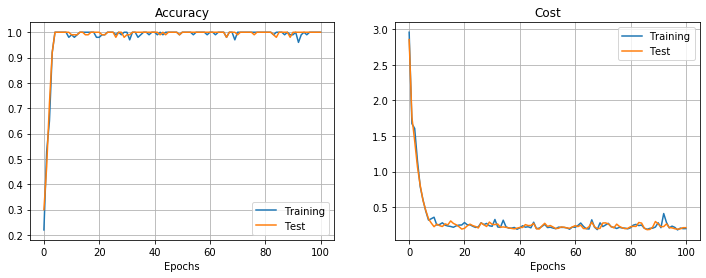

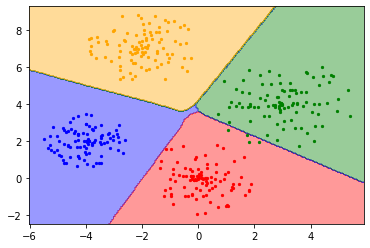

In [75]:
import numpy
from matplotlib import pyplot as plt

# データ作成
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data


N_train = 300
N_test = 100
N = N_train + N_test
data = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])
ids = np.random.choice(range(N), N, replace=False)
data = data[ids]
labels = labels[ids]


# 学習の設定
H_LAYERS = 5
H_UNITS = 10

# 勾配チェック
mlp = SimpleMLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=2, eta=0.01, n_batch=50, l2=0.1,
                          debug_grad_check=True)
mlp.fit(data[:N_train], labels[:N_train], data[N_train:], labels[N_train:])
for err in mlp.grad_err:
    print(err)

# プロット
mlp = SimpleMLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=100, eta=1e-2, n_batch=32, l2=0.1)
mlp.fit(data[:N_train], labels[:N_train], data[N_train:], labels[N_train:])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.plot(range(len(mlp.acc_train)), mlp.acc_train, label='Training')
plt.plot(range(len(mlp.acc_test)), mlp.acc_test, label='Test')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.title('Cost')
plt.plot(range(len(mlp.cost_train)), mlp.cost_train, label='Training')
plt.plot(range(len(mlp.cost_test)), mlp.cost_test, label='Test')
plt.grid()
plt.legend()
plt.show()

plot(mlp, data, labels)
plt.show()

[2020/07/04 17:11:22] epoch 1 finished (acc=0.915, cost=0.47285817647512707)
[2020/07/04 17:11:33] epoch 2 finished (acc=0.943, cost=0.34347214984918245)
[2020/07/04 17:11:44] epoch 3 finished (acc=0.951, cost=0.2873860388462945)
[2020/07/04 17:11:56] epoch 4 finished (acc=0.947, cost=0.28129912352763187)
[2020/07/04 17:12:07] epoch 5 finished (acc=0.955, cost=0.25519468322327293)
[2020/07/04 17:12:19] epoch 6 finished (acc=0.943, cost=0.31559625757563764)
[2020/07/04 17:12:30] epoch 7 finished (acc=0.955, cost=0.2561093417688498)
[2020/07/04 17:12:42] epoch 8 finished (acc=0.958, cost=0.27879865482321986)
[2020/07/04 17:12:53] epoch 9 finished (acc=0.961, cost=0.21415837053777745)
[2020/07/04 17:13:05] epoch 10 finished (acc=0.952, cost=0.27640390166955664)


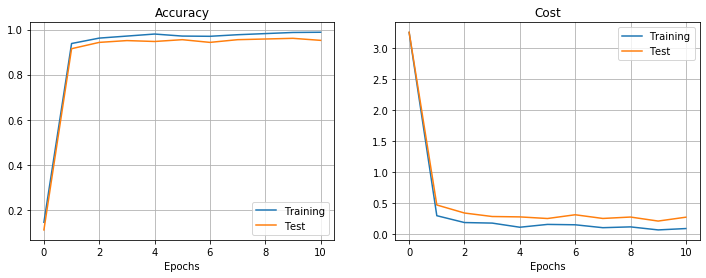

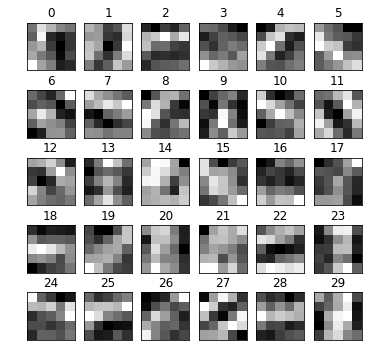

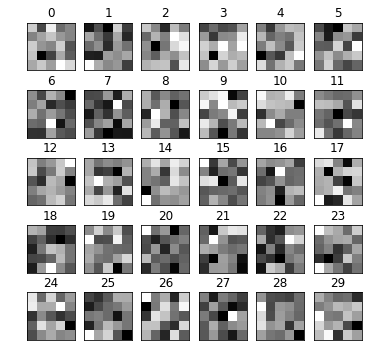

In [76]:
data = []
labels = []

def load_data(filename):
    data = []
    labels = []
    with open(filename) as f:
        lines = f.readlines()
        h, w = lines[0].split(',')
        h, w = int(h), int(w)
        for l in lines[1:]:
            arr = l.split(',')
            labels.append(arr[0])
            data.append([float(v) for v in arr[1:]])
        data = np.array(data).reshape(-1, 1, h, w)
        labels = np.array(labels)
    return data, labels

data_train, labels_train = load_data('../data/mnist/mnist_train')
data_test, labels_test = load_data('../data/mnist/mnist_test')

# 時間がかかる場合はこちらの小さい方のデータを使う
N_train = 5000
N_test = 1000
ids = np.random.choice(range(len(data_train)), N_train, replace=False)
data_train_s, labels_train_s = data_train[ids], labels_train[ids]
ids = np.random.choice(range(len(data_test)), N_test, replace=False)
data_test_s, labels_test_s = data_test[ids], labels_test[ids]


# 勾配チェック
# MaxPooling を入れると性能が悪い。「ゼロから作る」を丸コピしてもダメ。
#cnn = CNNClassifier(FN=2, FH=3, FW=3, PH=2, PW=2, h_units=2, h_layers=1, conv_layers=1, epochs=1, eta=1e-1, n_batch=25, l2=1e-3,
#          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0, debug_grad_check=True)
#cnn.fit(data_train_s[:50], labels_train_s[:50], data_test_s[:10], labels_test_s[:10])


cnn = CNNClassifier(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, conv_layers=1, epochs=10, eta=1e-2, n_batch=128, l2=1e-3,
                    stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
#cnn.fit(data_train, labels_train, data_test, labels_test)  # 1エポックに1分強かかる
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.plot(range(len(cnn.acc_train)), cnn.acc_train, label='Training')
plt.plot(range(len(cnn.acc_test)), cnn.acc_test, label='Test')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.title('Cost')
plt.plot(range(len(cnn.cost_train)), cnn.cost_train, label='Training')
plt.plot(range(len(cnn.cost_test)), cnn.cost_test, label='Test')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
for i in range(cnn.FN):
    plt.subplot(cnn.FN//6, 6, i+1)
    plt.title(i)
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
plt.show()

cnn = CNNClassifier(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, conv_layers=1, epochs=0, eta=1e-1, n_batch=128, l2=1e-3,
                    stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)
plt.figure(figsize=(6, 6))
for i in range(cnn.FN):
    plt.subplot(cnn.FN//6, 6, i+1)
    plt.title(i)
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
plt.show()

epoch 1 --- 2020/06/28 22:07:11
epoch 2 --- 2020/06/28 22:07:21
epoch 3 --- 2020/06/28 22:07:32
epoch 4 --- 2020/06/28 22:07:43
epoch 5 --- 2020/06/28 22:07:54
epoch 6 --- 2020/06/28 22:08:05
epoch 7 --- 2020/06/28 22:08:16
epoch 8 --- 2020/06/28 22:08:29
epoch 9 --- 2020/06/28 22:08:41
epoch 10 --- 2020/06/28 22:08:54
epoch 1 --- 2020/06/28 22:09:08
epoch 2 --- 2020/06/28 22:09:19
epoch 3 --- 2020/06/28 22:09:31
epoch 4 --- 2020/06/28 22:09:42
epoch 5 --- 2020/06/28 22:09:54
epoch 6 --- 2020/06/28 22:10:06
epoch 7 --- 2020/06/28 22:10:19
epoch 8 --- 2020/06/28 22:10:31
epoch 9 --- 2020/06/28 22:10:43
epoch 10 --- 2020/06/28 22:10:57
epoch 1 --- 2020/06/28 22:11:13
epoch 2 --- 2020/06/28 22:11:26
epoch 3 --- 2020/06/28 22:11:40
epoch 4 --- 2020/06/28 22:11:54
epoch 5 --- 2020/06/28 22:12:07
epoch 6 --- 2020/06/28 22:12:18
epoch 7 --- 2020/06/28 22:12:29
epoch 8 --- 2020/06/28 22:12:41
epoch 9 --- 2020/06/28 22:12:52
epoch 10 --- 2020/06/28 22:13:03
epoch 1 --- 2020/06/28 22:13:17
epoch

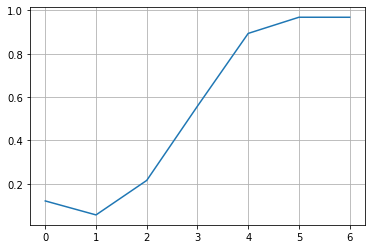

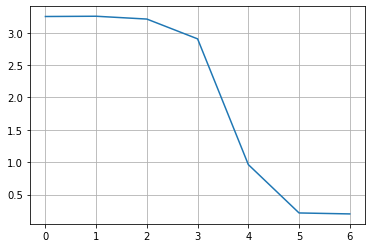

In [326]:
etas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
models = []
for eta in etas:
    cnn = CNNClassifier(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, conv_layers=1, epochs=10, eta=eta, n_batch=128, l2=1e-3,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
    #cnn.fit(data_train, labels_train, data_test, labels_test)  # 1エポックに1分強かかる
    cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)
    models.append(cnn)
plt.plot(range(len(models)), [np.average(m.acc_test[-10:]) for m in models])
plt.grid()
plt.show()
plt.plot(range(len(models)), [np.average(m.cost_test[-10:]) for m in models])
plt.grid()
plt.show()

In [80]:
# 画像読み込み
from PIL import Image, UnidentifiedImageError
import numpy as np
import os

IMG_SIZE=64

def load_images(img_dir):
    images = []
    for img_file in os.listdir(path=img_dir):
        try:
            img = Image.open(img_dir + '/' + img_file).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            images.append(np.asarray(img).transpose(2, 0, 1))
        except UnidentifiedImageError as e:
            print(e)
    print('{} images are loaded'.format(len(images)))
    return images

img_dirs = {
    'ladybug': '../data/image-net/images/ladybug',
    'spider': '../data/image-net/images/wolf_spider',
    #'garden_spider': '../data/image-net/images/garden_spider',
    'cockroach': '../data/image-net/images/cockroach'
}
images = {}

n_min = np.inf
for label, dir_path in img_dirs.items():
    images[label] = load_images(dir_path)
    if len(images[label]) < n_min:
        n_min = len(images[label])
data = []
labels = []
for k, v in images.items():
    data.extend(v[:n_min])
    labels.extend([k] * n_min)

data = np.array(data) / 255.0
labels = np.array(labels)

print('----------')
print('total {} images in data'.format(len(data)))

cannot identify image file '../data/image-net/images/ladybug/.DS_Store'
1536 images are loaded
cannot identify image file '../data/image-net/images/wolf_spider/.DS_Store'
1160 images are loaded
cannot identify image file '../data/image-net/images/cockroach/.DS_Store'
773 images are loaded
----------
total 2319 images in data


In [81]:
import numpy as np
import pickle

N_train = 1500
N_test = 500

N = len(data)
ids = np.array(range(N))
np.random.shuffle(ids)

data_train, labels_train = data[ids[:N_train]], labels[ids[:N_train]]
data_test, labels_test = data[ids[N_train:N_train+N_test]], labels[ids[N_train:N_train+N_test]]

with open('../data/tmp/data_train.pkl', 'xb') as f:
    pickle.dump(data_train, f)
with open('../data/tmp/data_test.pkl', 'xb') as f:
    pickle.dump(data_test, f)
with open('../data/tmp/labels_train.pkl', 'xb') as f:
    pickle.dump(labels_train, f)
with open('../data/tmp/labels_test.pkl', 'xb') as f:
    pickle.dump(labels_test, f)

In [82]:
vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
                        dropout_ratio=0.3)

[2020/07/04 17:27:51] epoch 1 finished (acc=0.58, cost=1.618672637233402)
[2020/07/04 17:30:34] epoch 2 finished (acc=0.63, cost=1.5380013483073482)
[2020/07/04 17:33:16] epoch 3 finished (acc=0.632, cost=1.4139547080959414)
[2020/07/04 17:35:58] epoch 4 finished (acc=0.69, cost=1.3527150230209337)
[2020/07/04 17:38:41] epoch 5 finished (acc=0.704, cost=1.2776265214533404)
[2020/07/04 17:41:23] epoch 6 finished (acc=0.672, cost=1.3215521795477585)
[2020/07/04 17:44:05] epoch 7 finished (acc=0.7, cost=1.297843943934763)
[2020/07/04 17:46:47] epoch 8 finished (acc=0.722, cost=1.187484626967132)
[2020/07/04 17:49:31] epoch 9 finished (acc=0.704, cost=1.2296536239207425)
[2020/07/04 17:52:13] epoch 10 finished (acc=0.726, cost=1.166334579818531)


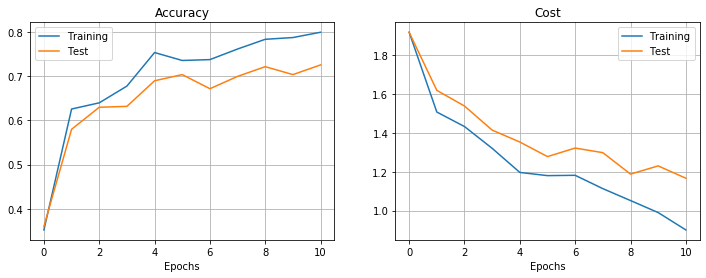

------------------------------------------------------------
All: 0.726 (363 / 500)
cockroach: 0.6235294117647059 (106 / 170)
ladybug: 0.7592592592592593 (123 / 162)
spider: 0.7976190476190477 (134 / 168)
------------------------------------------------------------
[2020/07/04 17:55:18] epoch 11 finished (acc=0.74, cost=1.1480337398829796)
[2020/07/04 17:58:00] epoch 12 finished (acc=0.714, cost=1.2072703851322397)
[2020/07/04 18:00:43] epoch 13 finished (acc=0.738, cost=1.1757965649068567)
[2020/07/04 18:03:26] epoch 14 finished (acc=0.752, cost=1.140987247355382)
[2020/07/04 18:06:09] epoch 15 finished (acc=0.74, cost=1.184913278602099)
[2020/07/04 18:08:52] epoch 16 finished (acc=0.742, cost=1.1295490857882082)
[2020/07/04 18:11:36] epoch 17 finished (acc=0.734, cost=1.1158977390577602)
[2020/07/04 18:14:19] epoch 18 finished (acc=0.724, cost=1.1614184951950022)
[2020/07/04 18:17:02] epoch 19 finished (acc=0.758, cost=1.1708314773976074)
[2020/07/04 18:19:45] epoch 20 finished (acc=

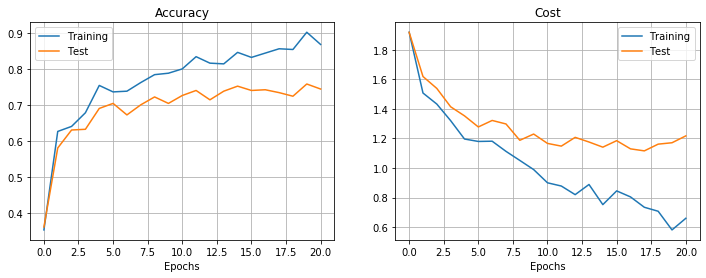

------------------------------------------------------------
All: 0.744 (372 / 500)
cockroach: 0.7176470588235294 (122 / 170)
ladybug: 0.7222222222222222 (117 / 162)
spider: 0.7916666666666666 (133 / 168)
------------------------------------------------------------
[2020/07/04 18:22:55] epoch 21 finished (acc=0.74, cost=1.2458366418477493)
[2020/07/04 18:25:38] epoch 22 finished (acc=0.742, cost=1.1777519500824751)
[2020/07/04 18:28:21] epoch 23 finished (acc=0.732, cost=1.2542734165885805)
[2020/07/04 18:31:05] epoch 24 finished (acc=0.728, cost=1.3312692143879725)
[2020/07/04 18:33:48] epoch 25 finished (acc=0.74, cost=1.209382245433786)
[2020/07/04 18:36:31] epoch 26 finished (acc=0.764, cost=1.2503068436645122)
[2020/07/04 18:39:14] epoch 27 finished (acc=0.758, cost=1.3655671906003664)
[2020/07/04 18:41:57] epoch 28 finished (acc=0.762, cost=1.2758307458898626)
[2020/07/04 18:44:40] epoch 29 finished (acc=0.76, cost=1.2324798180472616)
[2020/07/04 18:47:23] epoch 30 finished (acc=

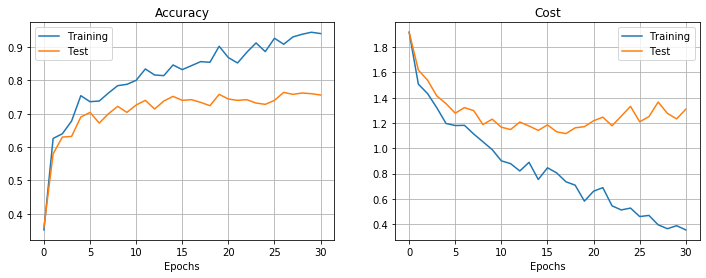

------------------------------------------------------------
All: 0.756 (378 / 500)
cockroach: 0.711764705882353 (121 / 170)
ladybug: 0.7777777777777778 (126 / 162)
spider: 0.7797619047619048 (131 / 168)
------------------------------------------------------------
[2020/07/04 18:50:29] epoch 31 finished (acc=0.75, cost=1.3528883681717057)
[2020/07/04 18:53:12] epoch 32 finished (acc=0.748, cost=1.4758130094954194)
[2020/07/04 18:55:56] epoch 33 finished (acc=0.738, cost=1.330480819760071)
[2020/07/04 18:58:40] epoch 34 finished (acc=0.756, cost=1.3044295107658472)
[2020/07/04 19:01:24] epoch 35 finished (acc=0.74, cost=1.4587346669594126)
[2020/07/04 19:04:07] epoch 36 finished (acc=0.748, cost=1.4347476034911464)
[2020/07/04 19:06:51] epoch 37 finished (acc=0.736, cost=1.4927254041874543)
[2020/07/04 19:09:35] epoch 38 finished (acc=0.742, cost=1.52725789822198)
[2020/07/04 19:12:18] epoch 39 finished (acc=0.736, cost=1.6518582253302723)
[2020/07/04 19:15:02] epoch 40 finished (acc=0.

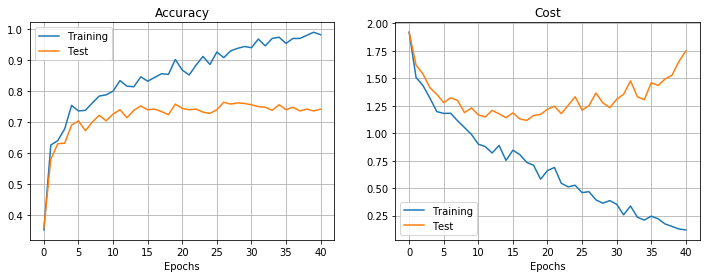

------------------------------------------------------------
All: 0.742 (371 / 500)
cockroach: 0.6411764705882353 (109 / 170)
ladybug: 0.7716049382716049 (125 / 162)
spider: 0.8154761904761905 (137 / 168)
------------------------------------------------------------
[2020/07/04 19:18:07] epoch 41 finished (acc=0.722, cost=1.9000292300231958)
[2020/07/04 19:20:51] epoch 42 finished (acc=0.752, cost=1.7408836097325202)
[2020/07/04 19:23:35] epoch 43 finished (acc=0.748, cost=1.8689927792204593)
[2020/07/04 19:26:19] epoch 44 finished (acc=0.718, cost=1.87240341304412)
[2020/07/04 19:29:03] epoch 45 finished (acc=0.748, cost=1.8174151906108844)
[2020/07/04 19:31:48] epoch 46 finished (acc=0.766, cost=1.840724266815768)
[2020/07/04 19:34:32] epoch 47 finished (acc=0.718, cost=2.150637430326027)
[2020/07/04 19:37:17] epoch 48 finished (acc=0.732, cost=2.111854937753705)
[2020/07/04 19:40:01] epoch 49 finished (acc=0.736, cost=1.9914986679718372)
[2020/07/04 19:42:46] epoch 50 finished (acc=0

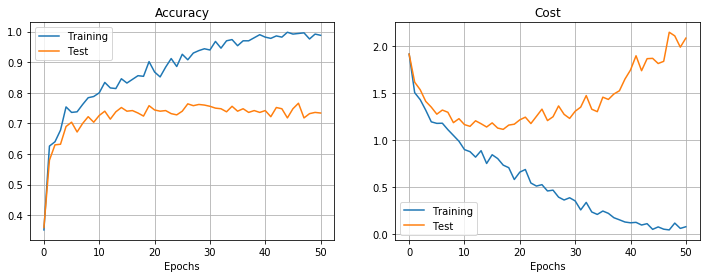

------------------------------------------------------------
All: 0.734 (367 / 500)
cockroach: 0.6647058823529411 (113 / 170)
ladybug: 0.7283950617283951 (118 / 162)
spider: 0.8095238095238095 (136 / 168)
------------------------------------------------------------


In [83]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pickle

#途中から再開する時
"""
with open('../data/tmp/vgg.pkl', 'rb') as f:
    vgg = pickle.load(f)
with open('../data/tmp/data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)
with open('../data/tmp/data_test.pkl', 'rb') as f:
    data_test = pickle.load(f)
with open('../data/tmp/labels_train.pkl', 'rb') as f:
    labels_train = pickle.load(f)
with open('../data/tmp/labels_test.pkl', 'rb') as f:
    labels_test = pickle.load(f)
"""

# Data Augmentation
# 左右反転・回転
"""
data_train_lr_flipped = np.flip(data_train, axis=3)
data_train_rot_l = np.rot90(data_train, 1, axes=(2, 3))
data_train_rot_r = np.rot90(data_train, 3, axes=(2, 3))
"""

for i in range(5):
    vgg.fit(data_train, labels_train, data_test, labels_test)
    
    try:
        with open('../data/tmp/vgg.pkl'.format(len(vgg.cost_train)), 'wb') as f:
            pickle.dump(vgg, f)
    except OverflowError as err:
        print(err)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.plot(range(len(vgg.acc_train)), vgg.acc_train, label='Training')
    plt.plot(range(len(vgg.acc_test)), vgg.acc_test, label='Test')
    plt.grid()
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.title('Cost')
    plt.plot(range(len(vgg.cost_train)), vgg.cost_train, label='Training')
    plt.plot(range(len(vgg.cost_test)), vgg.cost_test, label='Test')
    plt.grid()
    plt.legend()
    plt.show()

    """
    plt.figure(figsize=(6, 6))
    for i in range(cnn.FN):
        plt.subplot(cnn.FN//6, 6, i+1)
        plt.title(i)
        plt.xticks(color="None")
        plt.yticks(color="None")
        plt.tick_params(length=0)
        plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
    plt.show()
    """

    print('------------------------------------------------------------')
    labels_pred = vgg.predict(data_test)
    accuracy_array = labels_test == labels_pred
    n_total = len(accuracy_array)
    n_ok = np.count_nonzero(accuracy_array)
    print('All: {} ({} / {})'.format(n_ok/n_total, n_ok, n_total))
    for l in np.unique(labels_test):
        ids = np.where(labels_test == l)[0]
        n_total = len(ids)
        n_ok = np.count_nonzero(accuracy_array[ids])
        print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))
    print('------------------------------------------------------------')

In [ ]:
labels_pred = vgg.predict(data_test)
accuracy_array = labels_test == labels_pred
n_total = len(accuracy_array)
n_ok = np.count_nonzero(accuracy_array)
print('All: {} ({} / {})'.format(n_ok/n_total, n_ok, n_total))
for l in np.unique(labels_test):
    ids = np.where(labels_test == l)[0]
    ids_ng = np.intersect1d(np.where(labels_pred != l)[0], np.where(labels_test == l)[0])
    n_total = len(ids)
    n_ok = np.count_nonzero(accuracy_array[ids])
    print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))
    n_ng = len(ids_ng)
    plt.figure(figsize=(15, 2*n_ng//10))
    for i in range(n_ng):
        plt.subplot(n_ng//10+1, 10, i+1)
        plt.title(labels_pred[ids_ng[i]])
        plt.xticks(color="None")
        plt.yticks(color="None")
        plt.tick_params(length=0)
        img = Image.fromarray(np.uint8(data_test[ids_ng[i]].transpose(1,2,0)*255.0))
        plt.imshow(img)
    plt.show()

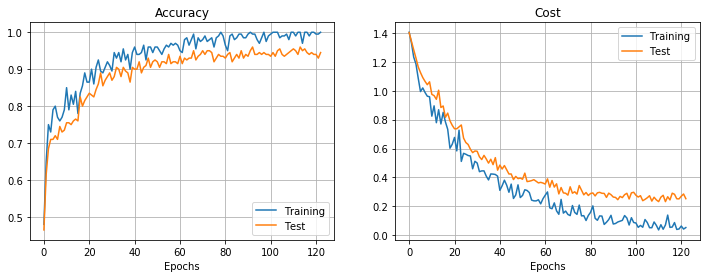

All: spider (0.945 / 189)
ladybug: 0.9230769230769231 (96 / 104)
spider: 0.9789473684210527 (93 / 95)


In [476]:
# ベースライン
# ladybug vs spider, 64x64, (N_train, N_test) = (1000, 200)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

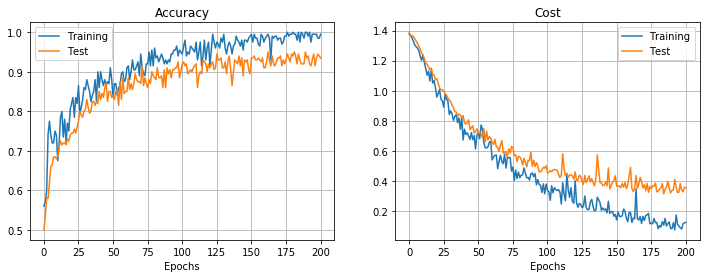

All: 0.935 (187 / 200)
ladybug: 0.8942307692307693 (93 / 104)
spider: 0.9791666666666666 (94 / 96)


In [492]:
# Dropout 0.3 -> 0.5：収束までの時間は増加、最終的な性能は変わらず
# ladybug vs spider, 64x64, (N_train, N_test) = (1000, 200)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.5)

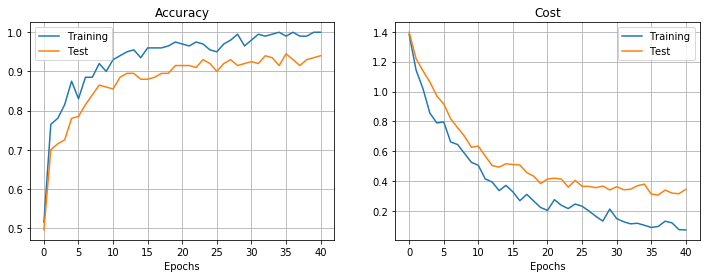

All: 0.93 (186 / 200)
ladybug: 0.8846153846153846 (92 / 104)
spider: 0.9791666666666666 (94 / 96)


In [495]:
# Dropout 0.3 -> 0：高速で収束、性能あまり変わらず。Dropout 不要？
# ladybug vs spider, 64x64, (N_train, N_test) = (1000, 200)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0)

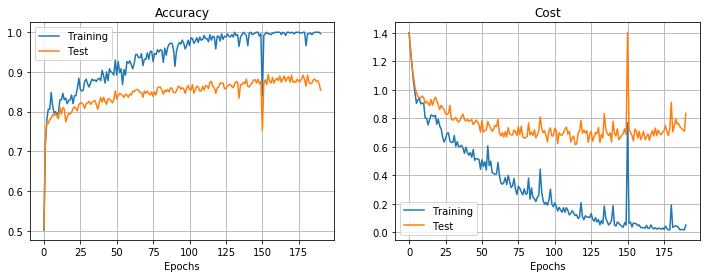

All: 0.854 (427 / 500)
cockroach: 0.8943089430894309 (220 / 246)
ladybug: 0.8149606299212598 (207 / 254)


In [30]:
# 比較対象を変更：
# ladybug vs cockroach, 64x64, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

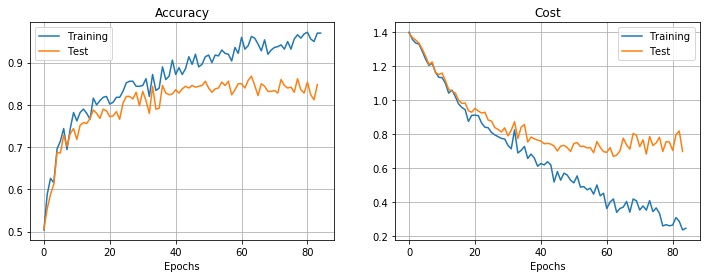

All: 0.836 (418 / 500)
cockroach: 0.8287937743190662 (213 / 257)
spider: 0.8436213991769548 (205 / 243)


In [15]:
# 比較対象を変更：比較的性能が低い & 過学習の度合いが大きい
# spider vs cockroach, 64x64, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

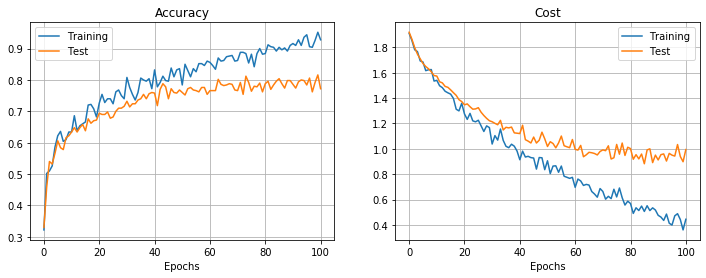

All: 0.772 (386 / 500)
cockroach: 0.7987012987012987 (123 / 154)
ladybug: 0.8421052631578947 (144 / 171)
spider: 0.68 (119 / 175)


In [522]:
# 3値分類へ変更：2値分類に比べて性能が出ない
# ladybug vs spider vs cockroach, 64x64, (N_train, N_test) = (1500, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

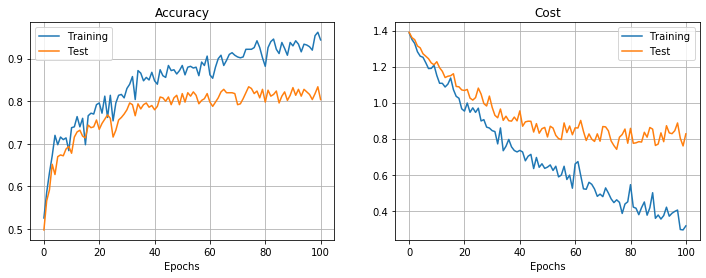

All: 0.804 (402 / 500)
cockroach: 0.7976190476190477 (201 / 252)
spider: 0.8104838709677419 (201 / 248)


In [536]:
# 128x128 画像に変更して、spider vs cockroach の2値分類リベンジ：
#   - 1 epoch の時間：1m -> 10m
#   - モデルサイズ：72MB -> 285MB
#   - 性能：あまり変わらない -> 解像度はそれほど問題ではない？
# spider vs cockroach, 128x128, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

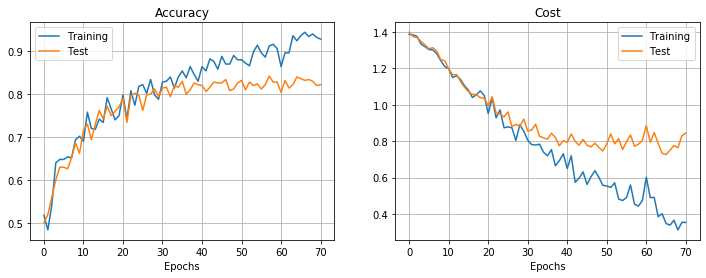

All: 0.822 (411 / 500)
cockroach: 0.8482490272373541 (218 / 257)
spider: 0.7942386831275721 (193 / 243)


In [543]:
# 画像サイズを戻し、隠れ層を1層 -> 2層にしてみる：
#   - 1 epoch の時間：1m -> 1m15s
#   - モデルサイズ：72MB -> 88MB
#   - 性能：若干向上？ 過学習がマシに？
# spider vs cockroach, 64x64, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=2, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

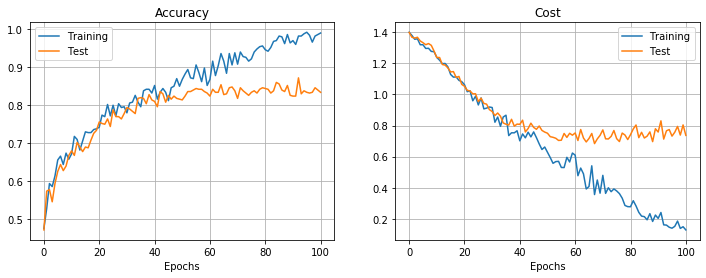

All: 0.834 (417 / 500)
cockroach: 0.8093385214007782 (208 / 257)
spider: 0.8600823045267489 (209 / 243)


In [553]:
# 隠れ層を1層 -> 3層にしてみる：
#   - 1 epoch の時間：1m -> 1m15s
#   - モデルサイズ：72MB -> 104MB
#   - 性能：2層のときよりもやや改善？
# spider vs cockroach, 64x64, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=3, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

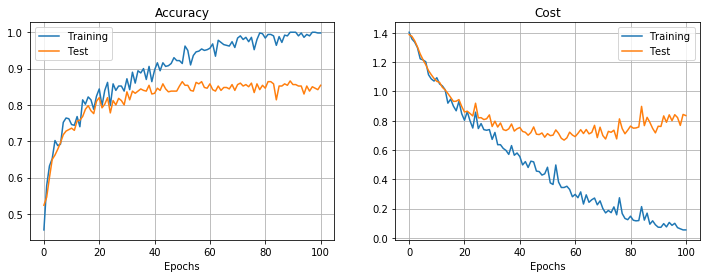

All: 0.854 (427 / 500)
cockroach: 0.8365758754863813 (215 / 257)
spider: 0.8724279835390947 (212 / 243)


In [559]:
# Conv-Conv-Pool 層の数を3 -> 4に増やしてみる：
#   - 1 epoch の時間：1m -> 1m30s
#   - モデルサイズ：72MB -> 44MB 減ってる...？
#   - 性能：変わらず
# spider vs cockroach, 64x64, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=4, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

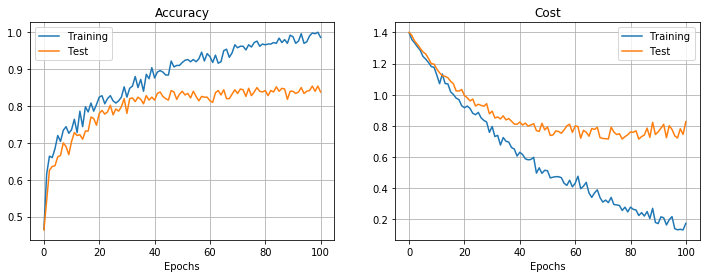

All: 0.838 (419 / 500)
cockroach: 0.8404669260700389 (216 / 257)
spider: 0.8353909465020576 (203 / 243)


In [564]:
# FNの初期値を2倍にしてみる：
#   - 1 epoch の時間：1m -> 3m10-30s
#   - モデルサイズ：72MB -> 146MB
#   - 性能：全然効果がなさそう
# spider vs cockroach, 64x64, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=32, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

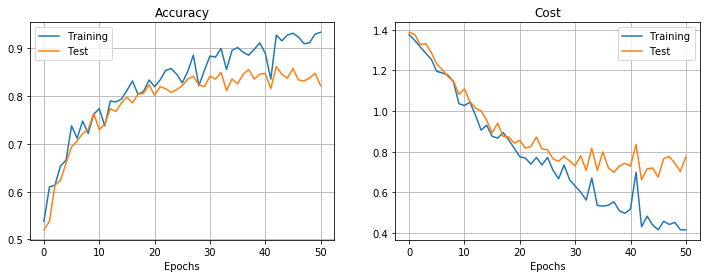

All: 0.822 (411 / 500)
cockroach: 0.8171206225680934 (210 / 257)
spider: 0.8271604938271605 (201 / 243)


In [578]:
# Conv-Conv-Pool -> Conv-Conv-Conv-Pool
#   - 1 epoch の時間：1m -> 2m
#   - モデルサイズ：72MB -> 141MB
#   - 性能：
# spider vs cockroach, 64x64, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

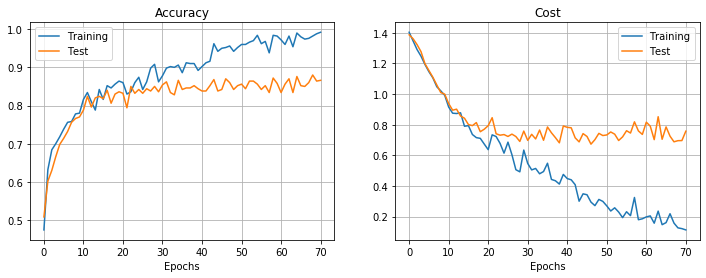

All: 0.866 (433 / 500)
cockroach: 0.867704280155642 (223 / 257)
spider: 0.8641975308641975 (210 / 243)


In [584]:
# Data Augmentation を試す：左右反転で2倍に
#   - 1 epoch の時間：1m -> 2m
#   - モデルサイズ：72MB -> 72MB
#   - 性能：
# data_train_lr_flipped = np.flip(data_train, axis=3)
# # np.rot90(x, 2, axes=(2, 3))
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, pool_layers=3, conv_layers_per_pool=2, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

In [ ]:
if True:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.plot(range(len(vgg.acc_train)), vgg.acc_train, label='Training')
    plt.plot(range(len(vgg.acc_test)), vgg.acc_test, label='Test')
    plt.grid()
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.title('Cost')
    plt.plot(range(len(vgg.cost_train)), vgg.cost_train, label='Training')
    plt.plot(range(len(vgg.cost_test)), vgg.cost_test, label='Test')
    plt.grid()
    plt.legend()
    plt.show()

    labels_pred = vgg.predict(data_test)
    accuracy_array = labels_test == labels_pred
    n_total = len(accuracy_array)
    n_ok = np.count_nonzero(accuracy_array)
    print('All: {} ({} / {})'.format(n_ok/n_total, n_ok, n_total))
    for l in np.unique(labels_test):
        ids = np.where(labels_test == l)[0]
        n_total = len(ids)
        n_ok = np.count_nonzero(accuracy_array[ids])
        print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))

# 犬猫分類

In [56]:
# 犬猫画像読み込み
from PIL import Image, UnidentifiedImageError
import numpy as np
import os

IMG_SIZE=128

def load_cats_and_dogs_images(img_dir):
    images_ = {'cat': [], 'dog': []}
    for img_file in os.listdir(path=img_dir):
        try:
            img = Image.open(img_dir + '/' + img_file).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            l = 'cat' if img_file[0].isupper() else 'dog'
            images_[l].append(np.asarray(img).transpose(2, 0, 1))
        except UnidentifiedImageError as e:
            print(e)
    for k, v in images_.items():
        print('{} {} images are loaded'.format(len(v), k))
    return images_

images = load_cats_and_dogs_images('../data/Oxford-IIIT-Pet-Dataset/images')

cannot identify image file '../data/Oxford-IIIT-Pet-Dataset/images/Abyssinian_102.mat'
cannot identify image file '../data/Oxford-IIIT-Pet-Dataset/images/Abyssinian_100.mat'
cannot identify image file '../data/Oxford-IIIT-Pet-Dataset/images/Abyssinian_101.mat'
2400 cat images are loaded
4990 dog images are loaded


In [57]:
N_train = 2000
N_test = 500
data_train = np.concatenate([images['dog'][:N_train//2], images['cat'][:N_train//2]])
labels_train = np.array(['dog']*(N_train//2) + ['cat']*(N_train//2))
data_test = np.concatenate([images['dog'][N_train//2:(N_train+N_test)//2], images['cat'][N_train//2:(N_train+N_test)//2]])
labels_test = np.array(['dog']*(N_test//2) + ['cat']*(N_test//2))

with open('../data/tmp/data_train.pkl', 'xb') as f:
    pickle.dump(data_train, f)
with open('../data/tmp/data_test.pkl', 'xb') as f:
    pickle.dump(data_test, f)
with open('../data/tmp/labels_train.pkl', 'xb') as f:
    pickle.dump(labels_train, f)
with open('../data/tmp/labels_test.pkl', 'xb') as f:
    pickle.dump(labels_test, f)

In [89]:
vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=2, pool_layers=4, conv_layers_per_pool=2, epochs=10, eta=1e-2, n_batch=64, l2=2e-3,
                        dropout_ratio=0.3)

[2020/07/04 23:58:31] epoch 51 finished (acc=0.79, cost=0.9156258915843691)
[2020/07/05 00:15:55] epoch 52 finished (acc=0.776, cost=0.9428934784199501)
[2020/07/05 00:33:18] epoch 53 finished (acc=0.766, cost=1.0276560454189314)
[2020/07/05 00:51:04] epoch 54 finished (acc=0.796, cost=0.9017492495542575)
[2020/07/05 01:08:31] epoch 55 finished (acc=0.786, cost=0.9973454510363773)
[2020/07/05 01:26:13] epoch 56 finished (acc=0.778, cost=0.9234825327190953)
[2020/07/05 01:44:02] epoch 57 finished (acc=0.8, cost=0.9723733807152249)
[2020/07/05 02:01:33] epoch 58 finished (acc=0.778, cost=1.0021273991584765)
[2020/07/05 02:19:27] epoch 59 finished (acc=0.804, cost=0.9687566152815933)
[2020/07/05 02:37:04] epoch 60 finished (acc=0.802, cost=0.9400824225019225)


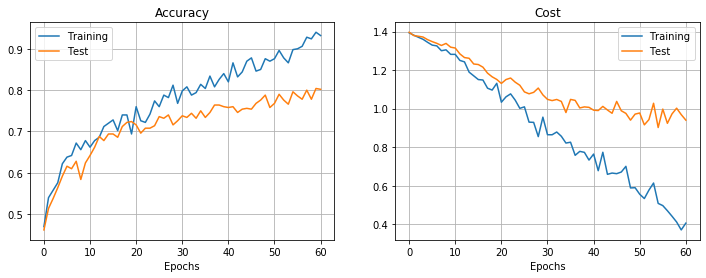

------------------------------------------------------------
All: 0.802 (401 / 500)
cat: 0.844 (211 / 250)
dog: 0.76 (190 / 250)
------------------------------------------------------------
[2020/07/05 02:57:31] epoch 61 finished (acc=0.806, cost=0.8981171687258844)
[2020/07/05 03:15:13] epoch 62 finished (acc=0.79, cost=0.9199752728153057)
[2020/07/05 03:32:47] epoch 63 finished (acc=0.786, cost=1.0579950065080774)
[2020/07/05 03:50:09] epoch 64 finished (acc=0.794, cost=0.9353127027872596)
[2020/07/05 04:08:01] epoch 65 finished (acc=0.798, cost=0.9819357531648135)
[2020/07/05 04:25:45] epoch 66 finished (acc=0.796, cost=0.9558409633325742)
[2020/07/05 04:43:50] epoch 67 finished (acc=0.806, cost=0.9218046210243236)
[2020/07/05 05:01:26] epoch 68 finished (acc=0.818, cost=0.9067053350246181)
[2020/07/05 05:19:07] epoch 69 finished (acc=0.794, cost=0.9858506614690643)
[2020/07/05 05:36:54] epoch 70 finished (acc=0.798, cost=0.9530202986694688)


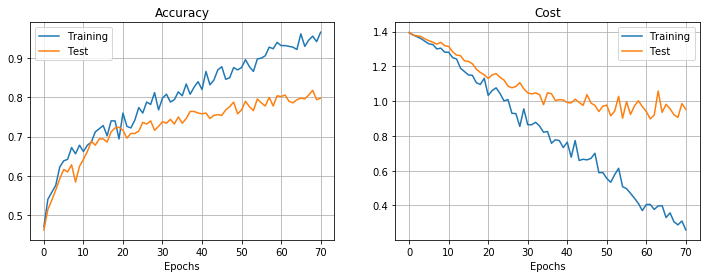

------------------------------------------------------------
All: 0.798 (399 / 500)
cat: 0.832 (208 / 250)
dog: 0.764 (191 / 250)
------------------------------------------------------------
[2020/07/05 05:57:18] epoch 71 finished (acc=0.812, cost=0.9264980852469175)
[2020/07/05 06:15:11] epoch 72 finished (acc=0.808, cost=0.9227256785869227)
[2020/07/05 06:32:50] epoch 73 finished (acc=0.806, cost=1.039682609244323)
[2020/07/05 06:50:27] epoch 74 finished (acc=0.806, cost=1.0034729668161972)
[2020/07/05 07:08:14] epoch 75 finished (acc=0.806, cost=1.068303087034564)
[2020/07/05 07:25:52] epoch 76 finished (acc=0.808, cost=1.00851007867493)
[2020/07/05 07:43:38] epoch 77 finished (acc=0.812, cost=0.9451546562514578)
[2020/07/05 08:01:05] epoch 78 finished (acc=0.8, cost=1.031969521412889)
[2020/07/05 08:18:26] epoch 79 finished (acc=0.822, cost=1.0047037380822232)
[2020/07/05 08:35:56] epoch 80 finished (acc=0.81, cost=0.9971323171183822)


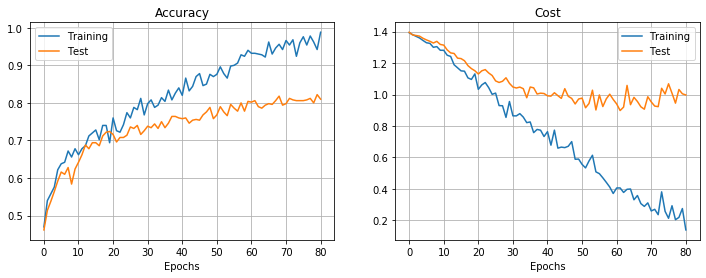

------------------------------------------------------------
All: 0.81 (405 / 500)
cat: 0.836 (209 / 250)
dog: 0.784 (196 / 250)
------------------------------------------------------------
[2020/07/05 08:56:09] epoch 81 finished (acc=0.82, cost=1.0157582494829032)
[2020/07/05 09:13:41] epoch 82 finished (acc=0.81, cost=0.9977597121597059)
[2020/07/05 09:31:17] epoch 83 finished (acc=0.814, cost=0.9612740316093139)
[2020/07/05 09:48:47] epoch 84 finished (acc=0.818, cost=1.0164932691220838)
[2020/07/05 10:06:18] epoch 85 finished (acc=0.828, cost=0.9219755078810453)
[2020/07/05 10:23:56] epoch 86 finished (acc=0.822, cost=0.9716101941980438)
[2020/07/05 10:41:41] epoch 87 finished (acc=0.816, cost=0.9490819077397874)
[2020/07/05 10:59:19] epoch 88 finished (acc=0.798, cost=1.0525452087932339)
[2020/07/05 11:17:01] epoch 89 finished (acc=0.81, cost=0.9680004135355832)
[2020/07/05 11:34:32] epoch 90 finished (acc=0.82, cost=0.9753438306929582)


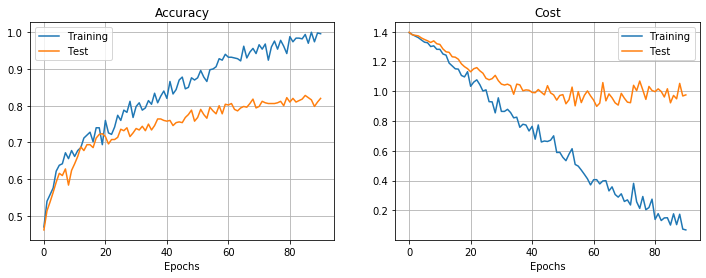

------------------------------------------------------------
All: 0.82 (410 / 500)
cat: 0.852 (213 / 250)
dog: 0.788 (197 / 250)
------------------------------------------------------------
[2020/07/05 11:55:09] epoch 91 finished (acc=0.818, cost=1.014028554636848)
[2020/07/05 12:12:48] epoch 92 finished (acc=0.826, cost=1.0136257490256708)
[2020/07/05 12:30:32] epoch 93 finished (acc=0.816, cost=0.9897695212174381)
[2020/07/05 12:48:09] epoch 94 finished (acc=0.82, cost=0.9843144767215343)
[2020/07/05 13:05:42] epoch 95 finished (acc=0.828, cost=1.0044716719195323)
[2020/07/05 13:23:27] epoch 96 finished (acc=0.81, cost=1.0767939789086762)
[2020/07/05 13:41:08] epoch 97 finished (acc=0.806, cost=1.2366644166026863)
[2020/07/05 13:59:00] epoch 98 finished (acc=0.822, cost=1.1123623383700836)
[2020/07/05 14:16:45] epoch 99 finished (acc=0.83, cost=0.9886521106716605)
[2020/07/05 14:34:28] epoch 100 finished (acc=0.83, cost=1.0746009028402226)


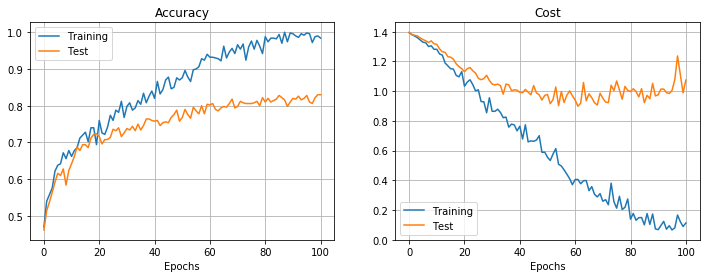

------------------------------------------------------------
All: 0.83 (415 / 500)
cat: 0.864 (216 / 250)
dog: 0.796 (199 / 250)
------------------------------------------------------------


In [94]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pickle

#途中から再開する時
"""
with open('../data/model_dogcat/vgg.pkl', 'rb') as f:
    vgg = pickle.load(f)
with open('../data/model_dogcat/data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)
with open('../data/model_dogcat/data_test.pkl', 'rb') as f:
    data_test = pickle.load(f)
with open('../data/model_dogcat/labels_train.pkl', 'rb') as f:
    labels_train = pickle.load(f)
with open('../data/model_dogcat/labels_test.pkl', 'rb') as f:
    labels_test = pickle.load(f)
"""

# Data Augmentation
# 左右反転・回転
"""
data_train_lr_flipped = np.flip(data_train, axis=3)
data_train_rot_l = np.rot90(data_train, 1, axes=(2, 3))
data_train_rot_r = np.rot90(data_train, 3, axes=(2, 3))
"""

for i in range(5):
    vgg.fit(data_train, labels_train, data_test, labels_test)
    #vgg.fit(np.concatenate([data_train, data_train_lr_flipped]), np.concatenate([labels_train, labels_train]), data_test, labels_test)
    
    try:
        with open('../data/model_dogcat/vgg.pkl'.format(len(vgg.cost_train)), 'wb') as f:
            pickle.dump(vgg, f)
    except OverflowError as err:
        print(err)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.plot(range(len(vgg.acc_train)), vgg.acc_train, label='Training')
    plt.plot(range(len(vgg.acc_test)), vgg.acc_test, label='Test')
    plt.grid()
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.title('Cost')
    plt.plot(range(len(vgg.cost_train)), vgg.cost_train, label='Training')
    plt.plot(range(len(vgg.cost_test)), vgg.cost_test, label='Test')
    plt.grid()
    plt.legend()
    plt.show()

    """
    plt.figure(figsize=(6, 6))
    for i in range(cnn.FN):
        plt.subplot(cnn.FN//6, 6, i+1)
        plt.title(i)
        plt.xticks(color="None")
        plt.yticks(color="None")
        plt.tick_params(length=0)
        plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
    plt.show()
    """

    print('------------------------------------------------------------')
    labels_pred = vgg.predict(data_test)
    accuracy_array = labels_test == labels_pred
    n_total = len(accuracy_array)
    n_ok = np.count_nonzero(accuracy_array)
    print('All: {} ({} / {})'.format(n_ok/n_total, n_ok, n_total))
    for l in np.unique(labels_test):
        ids = np.where(labels_test == l)[0]
        n_total = len(ids)
        n_ok = np.count_nonzero(accuracy_array[ids])
        print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))
    print('------------------------------------------------------------')